In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pickle
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'])
from common import *
from plotcommon import *
sys.path.append(os.environ['rapl'] + '/azav')
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
csfont = {'fontname':'DejaVu Serif'}
ticklabelsize = 10
plt.rcParams['xtick.labelsize'] = ticklabelsize
plt.rcParams['ytick.labelsize'] = ticklabelsize

import sys, os
from azav_util import plot_azav_half


In [2]:
# Get Rachel's solar data
di = get_dict('/mizar/loma3853/fixedflux/paperplots/gongdata/avgong.pkl')
Om = di['om']*1e-9*(2*np.pi) # nHz --> rad/s
rr = di['rr']*rsun
tt = di['tt']

cost = np.cos(tt)
sint = np.sin(tt)
nt = len(cost)
cost_2d = cost.reshape((nt, 1))
sint_2d = sint.reshape((nt, 1))

In [3]:
# look at r
rr

array([6.96193947e+10, 6.96020022e+10, 6.95832183e+10, 6.95603298e+10,
       6.95294407e+10, 6.94894379e+10, 6.94397650e+10, 6.93787521e+10,
       6.93034078e+10, 6.92087926e+10, 6.90872538e+10, 6.89275210e+10,
       6.87120628e+10, 6.84282867e+10, 6.80789062e+10, 6.76584251e+10,
       6.71572428e+10, 6.65714634e+10, 6.58996955e+10, 6.51402694e+10,
       6.42911675e+10, 6.33503029e+10, 6.23150317e+10, 6.11827799e+10,
       5.99502082e+10, 5.86137686e+10, 5.71694258e+10, 5.56124492e+10,
       5.39370644e+10, 5.21369407e+10, 5.02045644e+10, 4.81366657e+10,
       4.59567593e+10, 4.36766721e+10, 4.12993261e+10, 3.88242342e+10,
       3.62477788e+10, 3.35640465e+10, 3.07658715e+10, 2.78460882e+10,
       2.48004527e+10, 2.16318175e+10, 1.83538183e+10, 1.50028401e+10,
       1.16941604e+10, 8.69896323e+09, 6.25519871e+09, 4.31282518e+09,
       2.70508335e+09, 1.29888581e+09, 0.00000000e+00])

In [4]:
# Let's remove the r-values beyond two_cutoffs
#ircut = np.argmin(np.abs(rr - 4.176e10))
rr = di['rr']*rsun
Om = di['om']*1e-9*(2*np.pi) # nHz --> rad/s

rmax = 0.95
rmin = 0.5

irmin = np.argmin(np.abs(rr/rsun - rmin))
irmax = np.argmin(np.abs(rr/rsun - rmax))

rr = rr[irmax:irmin+1]
nr = len(rr)
rr_2d = rr.reshape((1, nr))

Om = Om[:, irmax:irmin+1]

print(rr)
print(nr)
print(np.shape(Om))

[6.58996955e+10 6.51402694e+10 6.42911675e+10 6.33503029e+10
 6.23150317e+10 6.11827799e+10 5.99502082e+10 5.86137686e+10
 5.71694258e+10 5.56124492e+10 5.39370644e+10 5.21369407e+10
 5.02045644e+10 4.81366657e+10 4.59567593e+10 4.36766721e+10
 4.12993261e+10 3.88242342e+10 3.62477788e+10 3.35640465e+10]
20
(49, 20)


In [5]:
dOmdr = drad(Om, rr)
dOmdt = dth(Om, tt)
dOmdz = cost_2d*dOmdr - sint_2d*dOmdt/rr_2d
dOmdl = sint_2d*dOmdr + cost_2d*dOmdt/rr_2d

In [6]:
# read in model S
fname_S = 'modelS.txt'
modelS = np.loadtxt(fname_S, skiprows=6)
print(np.shape(modelS))

(2482, 6)


In [7]:
rr_ref = modelS[:, 0]*rsun
cs_ref = modelS[:, 1]
rho_ref = modelS[:, 2]
P_ref = modelS[:, 3]
gam_ref = modelS[:, 4]
T_ref = modelS[:, 5]

In [8]:
# does radius array increase or decrease?
plt.figure()
plt.plot(rr_ref)

<IPython.core.display.Javascript object>

In [9]:
# integrate the density to get M(r), and hence g(r) = GM(r)/r^2
from scipy.integrate import simps
mass = np.zeros_like(rho_ref)
fp = 4*np.pi
integrand = rho_ref*fp*rr_ref**2

nr_ref = len(rr_ref)
for ir in range(nr_ref):
    mass[ir] = -simps(integrand[ir:], rr_ref[ir:])
print ('mass from integral:', mass[0])

mass from integral: 1.9865271445677947e+33


In [10]:
plt.figure()
plt.plot(rr_ref/rsun, mass)
plt.xlabel('r')
plt.ylabel('mass enclosed')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'mass enclosed')

In [11]:
plt.figure()
g_ref = G*mass/rr_ref**2
plt.plot(rr_ref/rsun, g_ref)
plt.xlabel('r')
plt.ylabel('g(r)')

<IPython.core.display.Javascript object>

/home5/loma3853/miniconda3/envs/custom/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'g(r)')

In [12]:
from scipy.interpolate import interp1d
# first interpolate density
f = interp1d(rr_ref, rho_ref)
rho = f(rr)

# then interpolate gravity
f = interp1d(rr_ref, g_ref)
g = f(rr)

In [13]:
# Plot the interpolation to make sure it worked
plt.figure()
plt.plot(rr_ref, rho_ref, 'k')
plt.plot(rr, rho, 'r--')

<IPython.core.display.Javascript object>

In [14]:
plt.figure()
plt.plot(rr_ref, g_ref, 'k')
plt.plot(rr, g, 'r--')
plt.show()

<IPython.core.display.Javascript object>

In [15]:
# Sweet...also interpolate pressure, temp, and define cP, pressure scale height
cp = 3.5e8

# get pressure scale height
dlnP_ref = np.gradient(P_ref, rr_ref)/P_ref
Hp_ref = -1./dlnP_ref
f = interp1d(rr_ref, Hp_ref)
Hp = f(rr)

# see what pressure scale height looks like
plt.figure()
plt.plot(rr_ref, Hp_ref, 'k')
plt.plot(rr, Hp, 'r--')
plt.ylim(0,1e10)

<IPython.core.display.Javascript object>

(0.0, 10000000000.0)

In [16]:
# Solve (non-D) thermal wind equations
dPdt = (rr_2d**2)*Om**2*sint_2d*cost_2d/g/Hp
dSdt = 2*Om*rr_2d**2*sint_2d*dOmdz/g

In [17]:
# look tt ... it's half the theta
tt

array([1.5708   , 1.53807  , 1.50535  , 1.47262  , 1.4399   , 1.40717  ,
       1.37445  , 1.34172  , 1.309    , 1.27627  , 1.24355  , 1.21082  ,
       1.1781   , 1.14537  , 1.11265  , 1.07992  , 1.0472   , 1.01447  ,
       0.981748 , 0.949023 , 0.916298 , 0.883573 , 0.850848 , 0.818123 ,
       0.785398 , 0.752673 , 0.719948 , 0.687223 , 0.654499 , 0.621774 ,
       0.589049 , 0.556324 , 0.523599 , 0.490874 , 0.458149 , 0.425424 ,
       0.392699 , 0.359974 , 0.327249 , 0.294524 , 0.261799 , 0.229074 ,
       0.19635  , 0.163625 , 0.1309   , 0.0981748, 0.0654498, 0.0327249,
       0.       ])

In [18]:
np.diff(tt)

array([-0.03273  , -0.03272  , -0.03273  , -0.03272  , -0.03273  ,
       -0.03272  , -0.03273  , -0.03272  , -0.03273  , -0.03272  ,
       -0.03273  , -0.03272  , -0.03273  , -0.03272  , -0.03273  ,
       -0.03272  , -0.03273  , -0.032722 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032725 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032724 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032725 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032725 , -0.032725 , -0.032725 , -0.032725 ,
       -0.032725 , -0.032724 , -0.032725 , -0.032725 , -0.0327252,
       -0.032725 , -0.0327249, -0.0327249])

In [19]:
# The latitudes are ~linearly spaced (thanks Rachel!) 
# Let's do Simpson integration from the equator
# to get S and P
from scipy.integrate import simps
nt = len(tt)
P_dev = np.zeros((nt, nr))
for ir in range(nr):
    dPdt_loc = dPdt[:, ir]
    for it in range(nt):
        P_dev[it, ir] = simps(dPdt_loc[:it+1], tt[:it+1])

In [20]:
# Integrate S
S_dev = np.zeros((nt, nr))
for ir in range(nr):
    dSdt_loc = dSdt[:, ir]
    for it in range(nt):
        S_dev[it, ir] = simps(dSdt_loc[:it+1], tt[:it+1])

In [21]:
# Get the temperature too
gam = 5./3.
T_dev = S_dev + (1. - 1./gam)*P_dev

In [22]:
print(np.shape(T_dev))
print(np.shape(rr))

(49, 20)
(20,)


In [24]:
# compute the dimensional thermo variables
# interpolate temperature
f = interp1d(rr_ref, T_ref)
T = f(rr)

f = interp1d(rr_ref, P_ref)
P = f(rr)

S_dev_dim = S_dev*cp
T_dev_dim = T_dev*T.reshape((1, nr))
P_dev_dim = P_dev*P.reshape((1, nr))

<IPython.core.display.Javascript object>


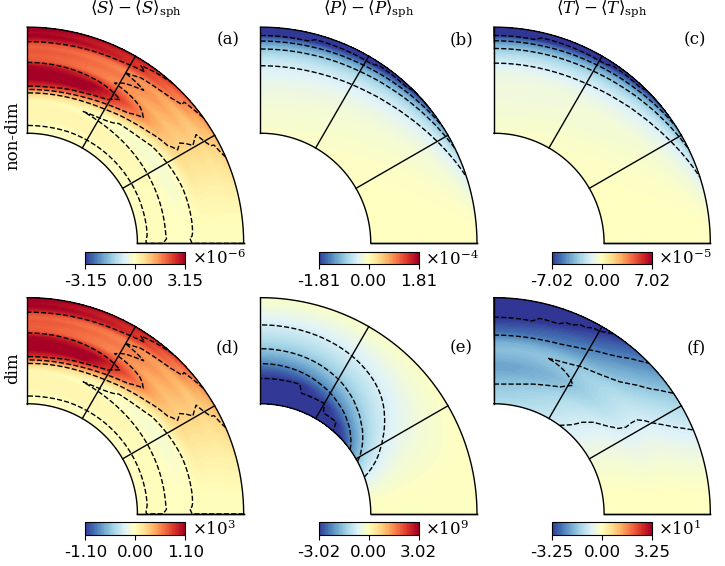

In [27]:
# Make figure
fig_width_inches = 7.25
margin_inches = 1./8.
margin_top_inches = 1./4.
margin_bottom_inches = 1/2
margin_left_inches = 1./4.
subplot_width_inches = (fig_width_inches - 3*margin_inches - margin_left_inches)/3
subplot_height_inches = subplot_width_inches
fig_height_inches = 2*(subplot_height_inches + margin_bottom_inches) + margin_top_inches

fig_aspect = fig_height_inches/fig_width_inches
margin_x = margin_inches/fig_width_inches
margin_y = margin_inches/fig_height_inches
margin_top = margin_top_inches/fig_height_inches
margin_bottom = margin_bottom_inches/fig_height_inches
margin_left = margin_left_inches/fig_width_inches

subplot_width = subplot_width_inches/fig_width_inches
subplot_height = subplot_height_inches/fig_height_inches
   
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

ax1 = fig.add_axes((margin_left, 1 - margin_top - subplot_height, subplot_width, subplot_height))   
ax2 = fig.add_axes((margin_left + 1*(subplot_width + margin_x),\
                    1 - margin_top - subplot_height, subplot_width, subplot_height))
ax3 = fig.add_axes((margin_left + 2*(subplot_width + margin_x),\
                    1 - margin_top - subplot_height, subplot_width, subplot_height))

ax4 = fig.add_axes((margin_left, margin_bottom, subplot_width, subplot_height))   
ax5 = fig.add_axes((margin_left + 1*(subplot_width + margin_x),\
                    margin_bottom, subplot_width, subplot_height))
ax6 = fig.add_axes((margin_left + 2*(subplot_width + margin_x),\
                    margin_bottom, subplot_width, subplot_height))

units_s = r'$\rm{erg\ g^{-1}\ K^{-1}}$'
units_p = r'$\rm{dyn\ cm^{-2}}$'
units_T = r'$\rm{K}$'

az_fs = 12
# Ignore part of NSSL...things will go crazy
#rcut = rr[0]
#rcut = 0.95*6.96e10
#ircut = np.argmin(np.abs(rr - rcut))
#ircut = 0
minmax = None
ircut = 0
#minmax=(-2.5e3, 2.5e3)
plot_azav_half (S_dev[:, ircut:], rr[ircut:], cost, fig=fig, ax=ax1, cbar_fs=az_fs,\
               units='', sym=None, minmax=minmax)
plot_azav_half (P_dev[:, ircut:], rr[ircut:], cost, fig=fig, ax=ax2, cbar_fs=az_fs,\
               units='', sym=None, minmax=minmax)
plot_azav_half (T_dev[:, ircut:], rr[ircut:], cost, fig=fig, ax=ax3, cbar_fs=az_fs,\
               units='',sym=None,  minmax=minmax)

plot_azav_half (S_dev_dim[:, ircut:], rr[ircut:], cost, fig=fig, ax=ax4, cbar_fs=az_fs,\
               units='', sym=None, minmax=minmax)
plot_azav_half (P_dev_dim[:, ircut:], rr[ircut:], cost, fig=fig, ax=ax5, cbar_fs=az_fs,\
               units='', sym=None, minmax=minmax)
plot_azav_half (T_dev_dim[:, ircut:], rr[ircut:], cost, fig=fig, ax=ax6, cbar_fs=az_fs,\
               units='',sym=None,  minmax=minmax)

# Label the plots with (a), (b), ...
fs = 12
fig.text(margin_left + subplot_width - margin_x/2, 1 - margin_top - margin_y/2, '(a)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 1*(margin_x + subplot_width),\
         1 - margin_top - margin_y/2, '(b)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 2*(margin_x + subplot_width),\
         1 - margin_top - margin_y/2, '(c)',\
         va='top', ha='right', **csfont, fontsize=fs)

fig.text(margin_left + subplot_width - margin_x/2, margin_y + subplot_height - margin_y/2, '(d)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 1*(margin_x + subplot_width),\
          margin_y + subplot_height - margin_y/2, '(e)',\
         va='top', ha='right', **csfont, fontsize=fs)
fig.text(margin_left + subplot_width - margin_x/2 + 2*(margin_x + subplot_width),\
          margin_y + subplot_height - margin_y/2, '(f)',\
         va='top', ha='right', **csfont, fontsize=fs)

# Label the top with the thermal variable
fig.text(margin_left + 0.5*subplot_width, 1 - margin_top + margin_y/2,\
         r'$\langle S\rangle - \langle S\rangle_{\rm{sph}}$', fontsize=fs, **csfont, ha='center', va='bottom')
fig.text(margin_left + 0.5*subplot_width + 1*(subplot_width + margin_x), 1 - margin_top + margin_y/2,\
         r'$\langle P\rangle - \langle P\rangle_{\rm{sph}}$', fontsize=fs, **csfont, ha='center', va='bottom')
fig.text(margin_left + 0.5*subplot_width + 2*(subplot_width + margin_x), 1 - margin_top + margin_y/2,\
         r'$\langle T\rangle - \langle T\rangle_{\rm{sph}}$', fontsize=fs, **csfont, ha='center', va='bottom')

# Label the left with nonD/dim
fig.text(0.5*margin_left, 1 - margin_top - 0.5*subplot_height, 'non-dim',\
         rotation=90, va='center', ha='center', **csfont, fontsize=fs)
fig.text(0.5*margin_left, 1 - margin_top - 0.5*subplot_height - (subplot_height + margin_y),\
         'dim',\
         rotation=90, va='center', ha='center', **csfont, fontsize=fs)

plt.savefig('thermo_merplane_Sun.png', dpi=300)